Group 35 Project Proposal: Predicting Heart Disease

Introduction

Heart disease is a very general term that describes a range of conditions that are often very detrimental to one's health. A main concern for many forms of heart disease is the narrowing of vessels, which leads to higher risk of blockages, and therefore death. There are many contributers to the presence of heart disease in a person, including sex, age, cholesterol levels, heart rate, and blood pressure. As one gets older, the heart may begin to weaken and the vessels may narrow. A build-up of cholesterol on the vessel walls also narrows the vessels and may cause blockages. High blood pressure can harden and/or thicken the vessel walls, causing them to narrow.

The data below has been collected from 294 different patients and reports on specific aspects of their health with the purpose of determining the presence of heart disease in a patient. Similar data has been collected from hospitals in Budapest, Cleveland, and Switzerland, originally with 76 different variables. For the purposes of this project, the data used will only contain 14 variables, and is taken from the Hungarian Institute of Cardiology in Budapest. The question to be answered is: How present is heart disease in a patient, with categorical values ranging from 0 (no heart disease present) to 4?


Preliminary Data Analysis

In [1]:
# Load package
library(tidyverse)
library(tidymodels)
library(digest)
library(GGally)
library(repr)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Read in the heart disease data, rename the column name and mutate all columns to be numeric
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data"
heart_disease <- read_delim(url, delim = " ", col_names = FALSE) %>%
                    rename(age = X1, sex = X2, chest_pain_type = X3, resting_BP = X4, cholesterol = X5, fasting_bs = X6, rest_ecg = X7,
                           max_hr = X8, ex_angina = X9, st_depression = X10, slope_st = X11, num_major_vessels = X12, thal = X13, diagnosis = X14)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_double(),
  X13 = col_double(),
  X14 = col_double()
)



In [3]:
# Mutate the diagnosis to be factors, and age, resting_BP, cholesteral, max_hr to be integer
heart_disease <- heart_disease %>%
                mutate(diagnosis = as.factor(diagnosis))%>%
                mutate(age = as.integer(age))%>%
                mutate(resting_BP = as.integer(resting_BP))%>%
                mutate(cholesterol = as.integer(cholesterol))%>%
                mutate(max_hr = as.integer(max_hr))

# Replace all "-9" as NA
heart_disease <- heart_disease %>%
                 mutate(across(where(is.numeric), ~na_if(., -9)))

# Select age, resting_BP, cholesteral, and amx_hr columns, remove any rows that contain NA
heart_disease_data <- heart_disease %>%
                      select(age, resting_BP, cholesterol, max_hr, diagnosis) %>%
                      na.omit() 

heart_disease_data

age,resting_BP,cholesterol,max_hr,diagnosis
<int>,<int>,<int>,<int>,<fct>
40,140,289,172,0
49,160,180,156,1
37,130,283,98,0
⋮,⋮,⋮,⋮,⋮
48,110,211,138,0
47,140,257,135,0
53,130,182,148,0


In [4]:
# Set the seed
set.seed(999) 

# Split the data into a training and test set

heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = diagnosis)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

heart_disease_train
heart_disease_test

age,resting_BP,cholesterol,max_hr,diagnosis
<int>,<int>,<int>,<int>,<fct>
40,140,289,172,0
49,160,180,156,1
39,120,339,170,0
⋮,⋮,⋮,⋮,⋮
51,110,190,120,0
36,120,166,180,0
48,110,211,138,0


age,resting_BP,cholesterol,max_hr,diagnosis
<int>,<int>,<int>,<int>,<fct>
37,130,283,98,0
48,138,214,108,3
54,120,273,150,0
⋮,⋮,⋮,⋮,⋮
55,110,344,160,0
47,140,257,135,0
53,130,182,148,0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



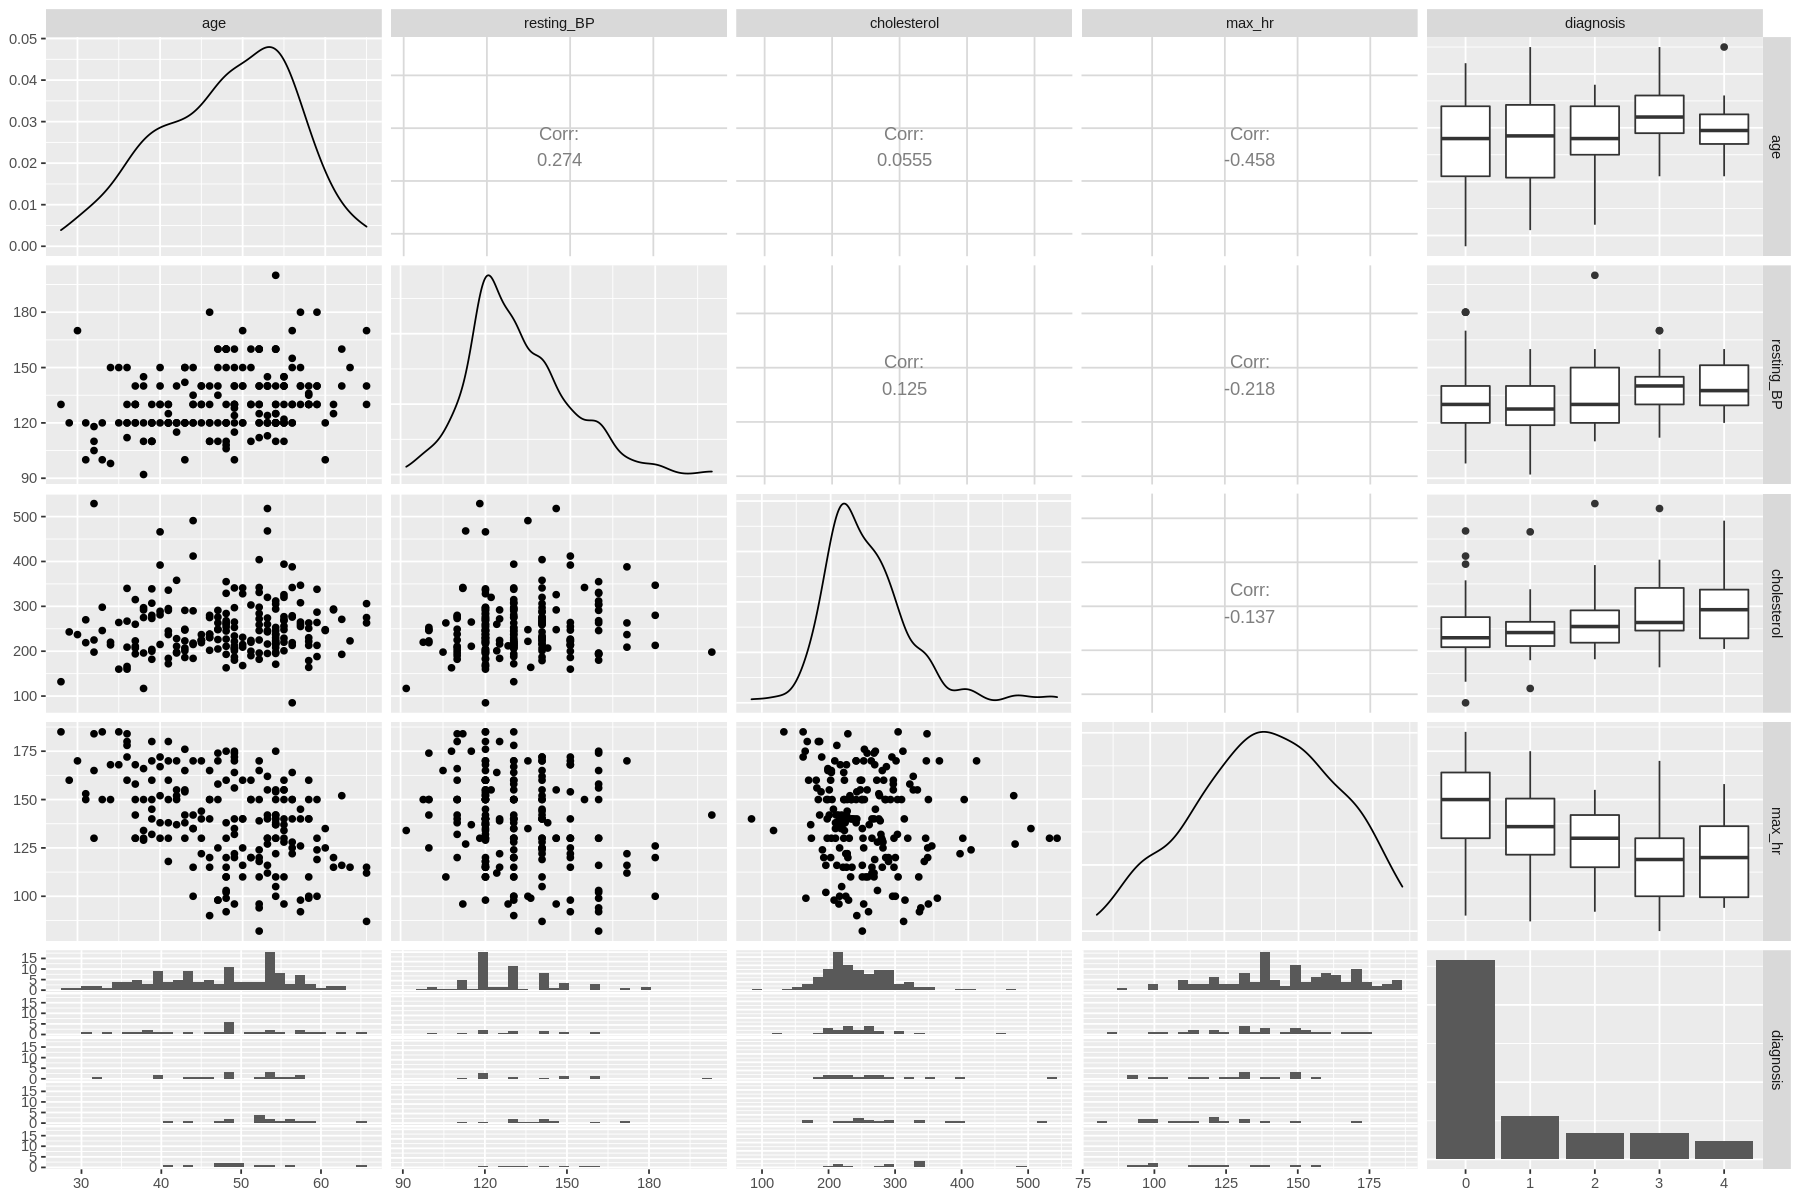

In [5]:
# Create a ggpairs scatterplot of all the columns we are interested in including in our model
options(repr.plot.width = 15, repr.plot.height = 10)
heart_disease_eda <- ggpairs(heart_disease_train)
heart_disease_eda

In [6]:
# Group by diagnosis and find average age, resting blood pressure, cholesteral and maximum heart rate achieved, 
# the number of observations, and percentage of participants in each group

heart_disease_train_table <- heart_disease_train %>%
                                select(age,resting_BP, max_hr, cholesterol, diagnosis)%>%
                                group_by(diagnosis)%>%
                                summarize(avg_age = round(mean(age), digits = 1),
                                          avg_resting_BP = round(mean(resting_BP),digits = 1),
                                          avg_max_hr = round(mean(max_hr),digits = 1),
                                          avg_cholesteral = round(mean(cholesterol),digits = 1),
                                          num_obs = n(),
                                          percentage = round(n()/ nrow(heart_disease_train)*100,digits = 1))

heart_disease_train_table

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,avg_age,avg_resting_BP,avg_max_hr,avg_cholesteral,num_obs,percentage
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0,47.1,129.6,146.2,243.6,129,63.5
1,48.2,128.3,135.5,245.9,28,13.8
2,48.7,138.7,126.2,275.4,17,8.4
3,52.6,139.6,117.9,289.1,17,8.4
4,50.3,139.0,120.9,297.6,12,5.9


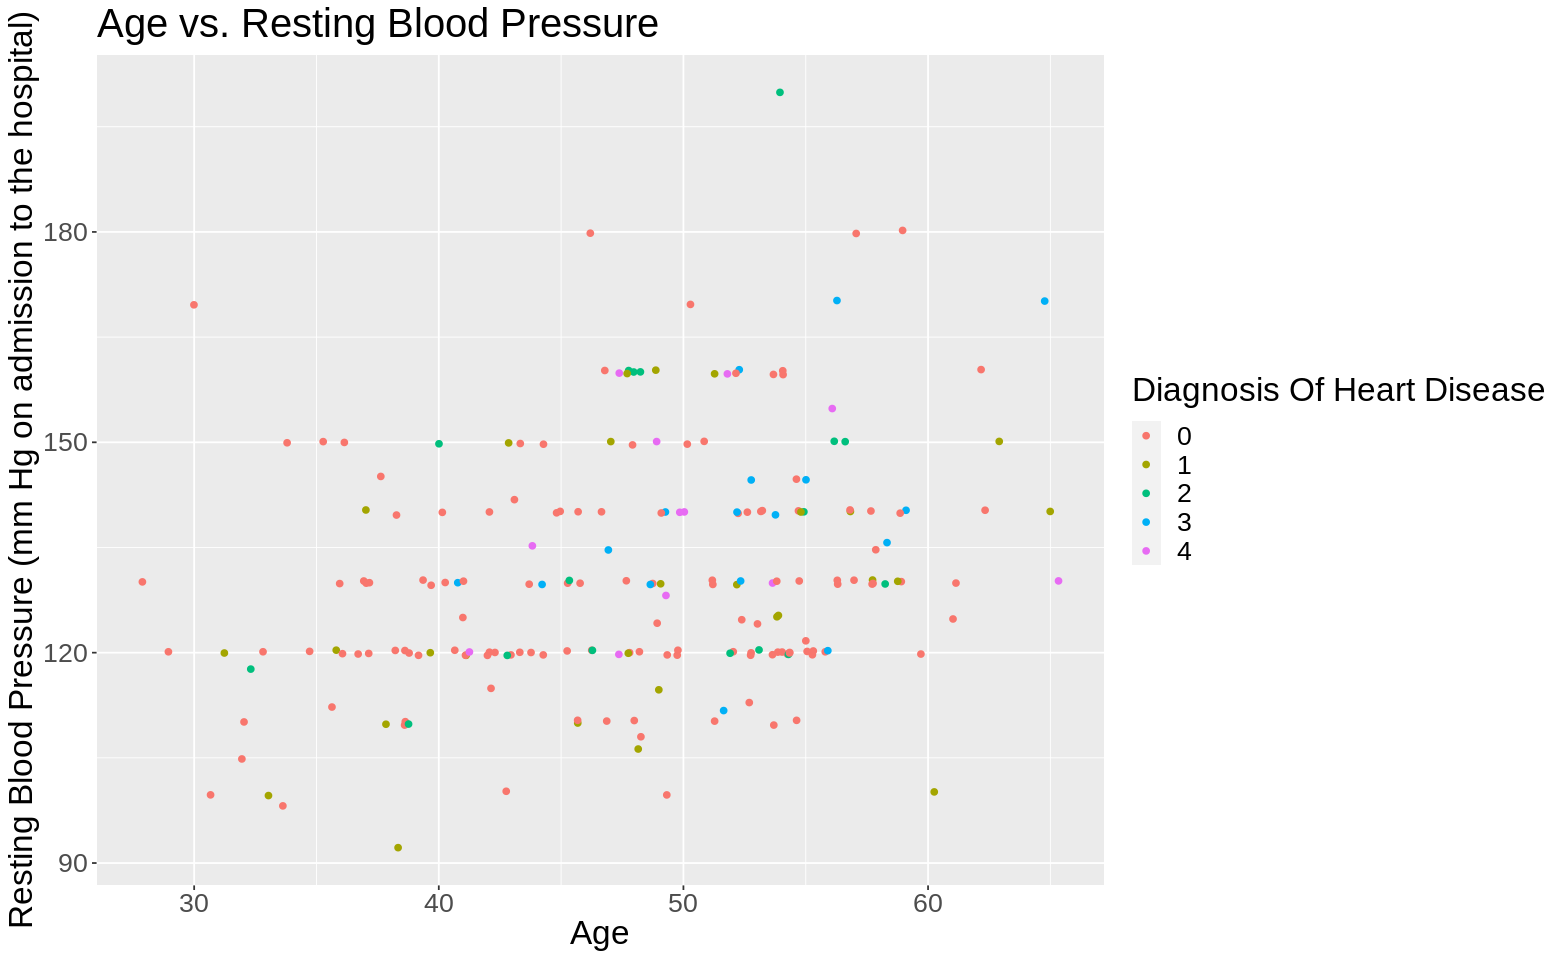

In [7]:
# Plot for age vs. resting blood pressure

options(repr.plot.width = 13, repr.plot.height = 8)

resting_BP_plot <- heart_disease_train %>%
                    ggplot(aes(x = age, y = resting_BP, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Resting Blood Pressure (mm Hg on admission to the hospital)", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Resting Blood Pressure")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)
resting_BP_plot

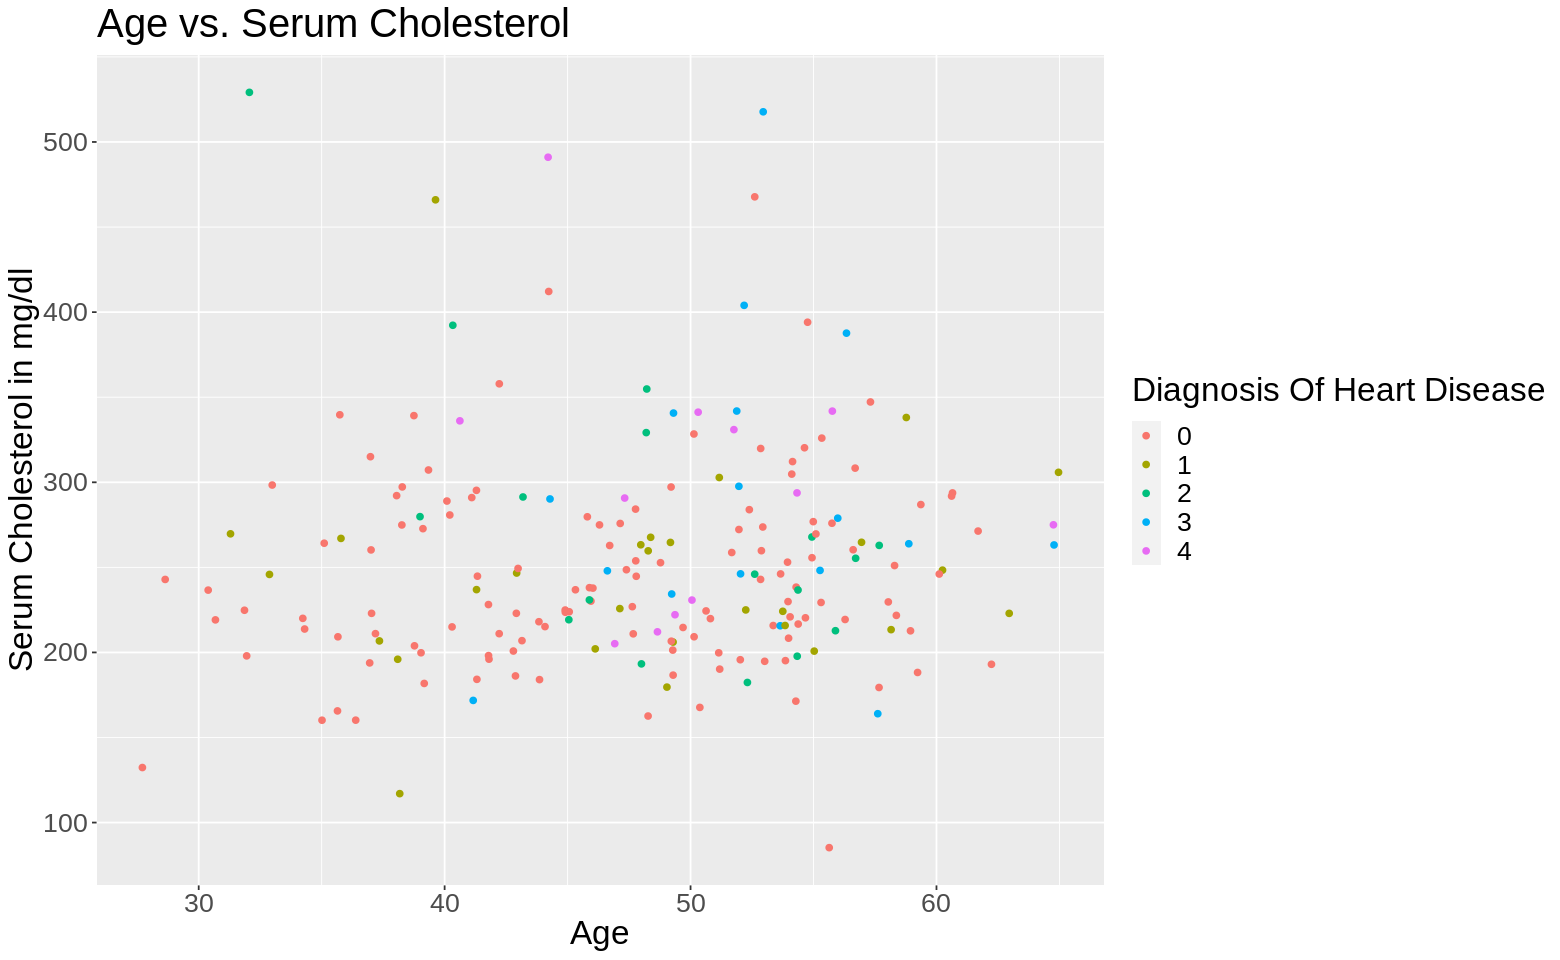

In [8]:
# Plot for age vs. cholesteral

options(repr.plot.width = 13, repr.plot.height = 8)

resting_BP_plot <- heart_disease_train %>%
                    ggplot(aes(x = age, y = cholesterol, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Serum Cholesterol in mg/dl", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Serum Cholesterol")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)
resting_BP_plot

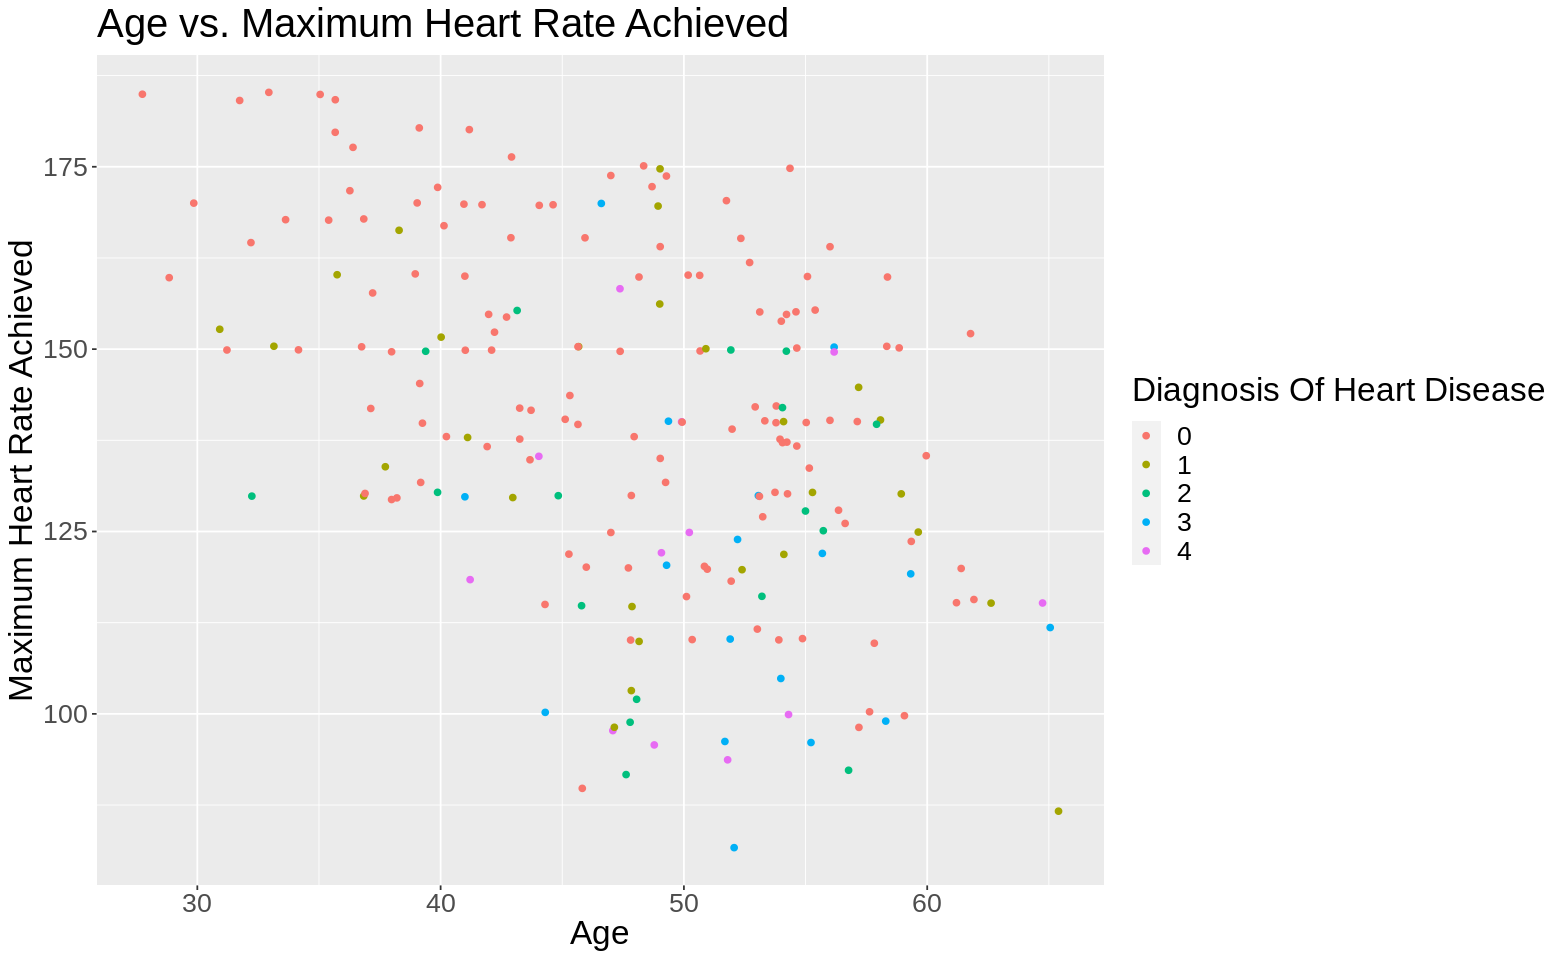

In [9]:
# Plot for age vs. maximum heart rate achieved

options(repr.plot.width = 13, repr.plot.height = 8)

max_hr_plot <- heart_disease_train %>%
                    ggplot(aes(x = age, y = max_hr, color = diagnosis))+
                    geom_point(position = "jitter")+
                    labs(x = "Age", y = "Maximum Heart Rate Achieved", colour = "Diagnosis Of Heart Disease")+
                    ggtitle("Age vs. Maximum Heart Rate Achieved")+
                    theme(text = element_text(size = 20))+
                    scale_y_continuous(labels = scales::comma)
max_hr_plot

Methods

We will use KNN classification as we are predicting a categorical value (diagnosis) from our predictors.  We will create a classifier, tune the classifier and visualize the results. The variables that will be used in the analysis are age, resting blood pressure, serum cholesterol, maximum heart rate achieved and diagnosis of heart disease.

From the ggpairs plot above, we can see a relatively strong relationship between the age predictor and the three predictors(age, resting_BP, cholesterol and max_hr). Thus, we will use average age, average resting blood pressure, average serum cholesterol and average maximum heart rate, which will be calculated by averaging the columns, as strong predictors for diagnosis.

age = (yrs);
resting_BP = resting blood pressure (mm Hg on admission to the hospital);
cholesterol = serum cholesterol in mg/dl;
max_hr = maximum heart rate achieved

The results will be visualized in three scatterplots with “age” on the x-axis and the others on the y-axis as well as the points being coloured to identify the diagnosis. We will also make a plot of predicted and true diagnosis values with a best-fit line through the true values, of "a variable" vs "diagnosis".


Expected outcomes and Significance

First, we expect to find the best KNN classifier which has the highest accuracy that predicts diagnosis.
Second, we expect to find the best fitted line for the age and one (or several) specific aspect(s) of health. 

Assuming that a positive relationship exists between age and cholesterol level, for instance, there should be a fitted line which has the least residues. And we can conclude that as people grow older, the possibility of obtaining a higher cholesterol becomes greater. If this conclusion holds true for age versus all other variables, we can say that people should pay more attention to heart disease as they grow older. 
This may lead to a few future questions. If there exists one or more variables that don’t have a linear relationship with sex, will the classification method still work? Hence, what conclusion should we draw from our data? What’s more, what will happen if we take “sex” into consideration? Will our primary conclusion still hold true? If it does, how do the slopes of the fitted lines differ between  males and females? If it doesn’t differ, what will our further conclusion be like? 
